In [2]:
import numpy as np
import scipy.linalg
from general_graph_utils_old import *
from tqdm import tqdm

In [3]:
def new_param_choice(G):
    """
    Extracts the label information for each edge in a NetworkX graph object. If G not labeled, labels are logarithmically sampled.
    
    Note: works for undirected graph, but if given a choice, better to use a directed graph
    
    Parameters
    ----------
    G : NetworkX graph object (directed)
            
    Returns
    -------
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
        
    """
    
    label_dict = {}
    
    if nx.is_weighted(G)==True:
        for i in range(len(G.edges())):
            label_dict[list(G.edges())[i]] = G.get_edge_data(list(G.edges)[i][0],list(G.edges)[i][1])['weight']
        
    elif nx.is_weighted(G)==False:
        label_dict = {e: 1.0 for e in G.edges}
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

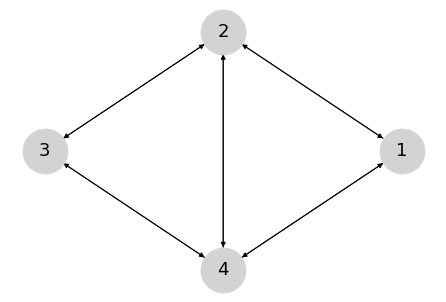

In [4]:
# create the graphs
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 2)
G.add_edge(2, 1)
G.add_edge(1, 4)
G.add_edge(4, 1)
G.add_edge(3, 4)
G.add_edge(4, 3)
G.add_edge(3, 2)
G.add_edge(2, 3)
G.add_edge(4, 2)
G.add_edge(2, 4)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
G_ud.add_edge(3, 4)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(4, 2)
G_ud.add_edge(2, 4)

nx.draw(G, 
        pos=nx.circular_layout(G), 
        with_labels=True, 
        node_size=2000, 
        node_color = 'lightgray', 
        font_size=18, 
        font_color='black', 
        font_family='sans-serif')

In [6]:
node_list = get_nodes(G)
edge_list = get_edges(G)
label_dict, label_list = new_param_choice(G)
cycle_list = get_cycle_nodes(G_ud)
L = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(L)
observable = [3,5,7,9]

In [11]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)

In [12]:
total_affinities

array([0., 0.], dtype=float128)

In [13]:
L

array([[-2.,  1.,  0.,  1.],
       [ 1., -3.,  1.,  1.],
       [ 0.,  1., -2.,  1.],
       [ 1.,  1.,  1., -3.]], dtype=float128)

In [19]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for autocorrelation function given a Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : 2D array
        column-based Laplacian matrix of system (including diagonal entries)
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent
    beta : scalar
        exponent
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable])
    fstar = f.T
    
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n))
    t_rev = np.zeros(len(tau_n))
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [20]:
tau_n = np.around(np.arange(0.01,2.0,step=.01), decimals = 2)

In [21]:
num_cycles = len(cycle_list)
N = 2000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
for i in tqdm(range(0,N)):
    
    # calculate and store the cycle affinity for each cycle
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    
    all_affinities[i] = total_affinities
    
    # edit the record of the weights in the graph
    for j in range(num_cycles):
        label_dict[edge_tracker[j]] = cycle_labels_forward[j][0]
    
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    # calculate the Laplacian
    L = Laplacian_all(edge_list,label_list,node_list)
    
    # calculate the autocorrelation functions
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    
    # calculate and store the area between them
    #print(np.abs(np.trapz(t_ex1)-np.trapz(t_rev_ex1)))
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))
    
    # perturb parameter in each cycle
    for cycle in cycle_labels_forward:
        cycle[0] = cycle[0]*1.01
    #cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01
    #cycle[0] = cycle[0]*1.01

100%|███████████████████████████████████████| 2000/2000 [02:48<00:00, 11.89it/s]


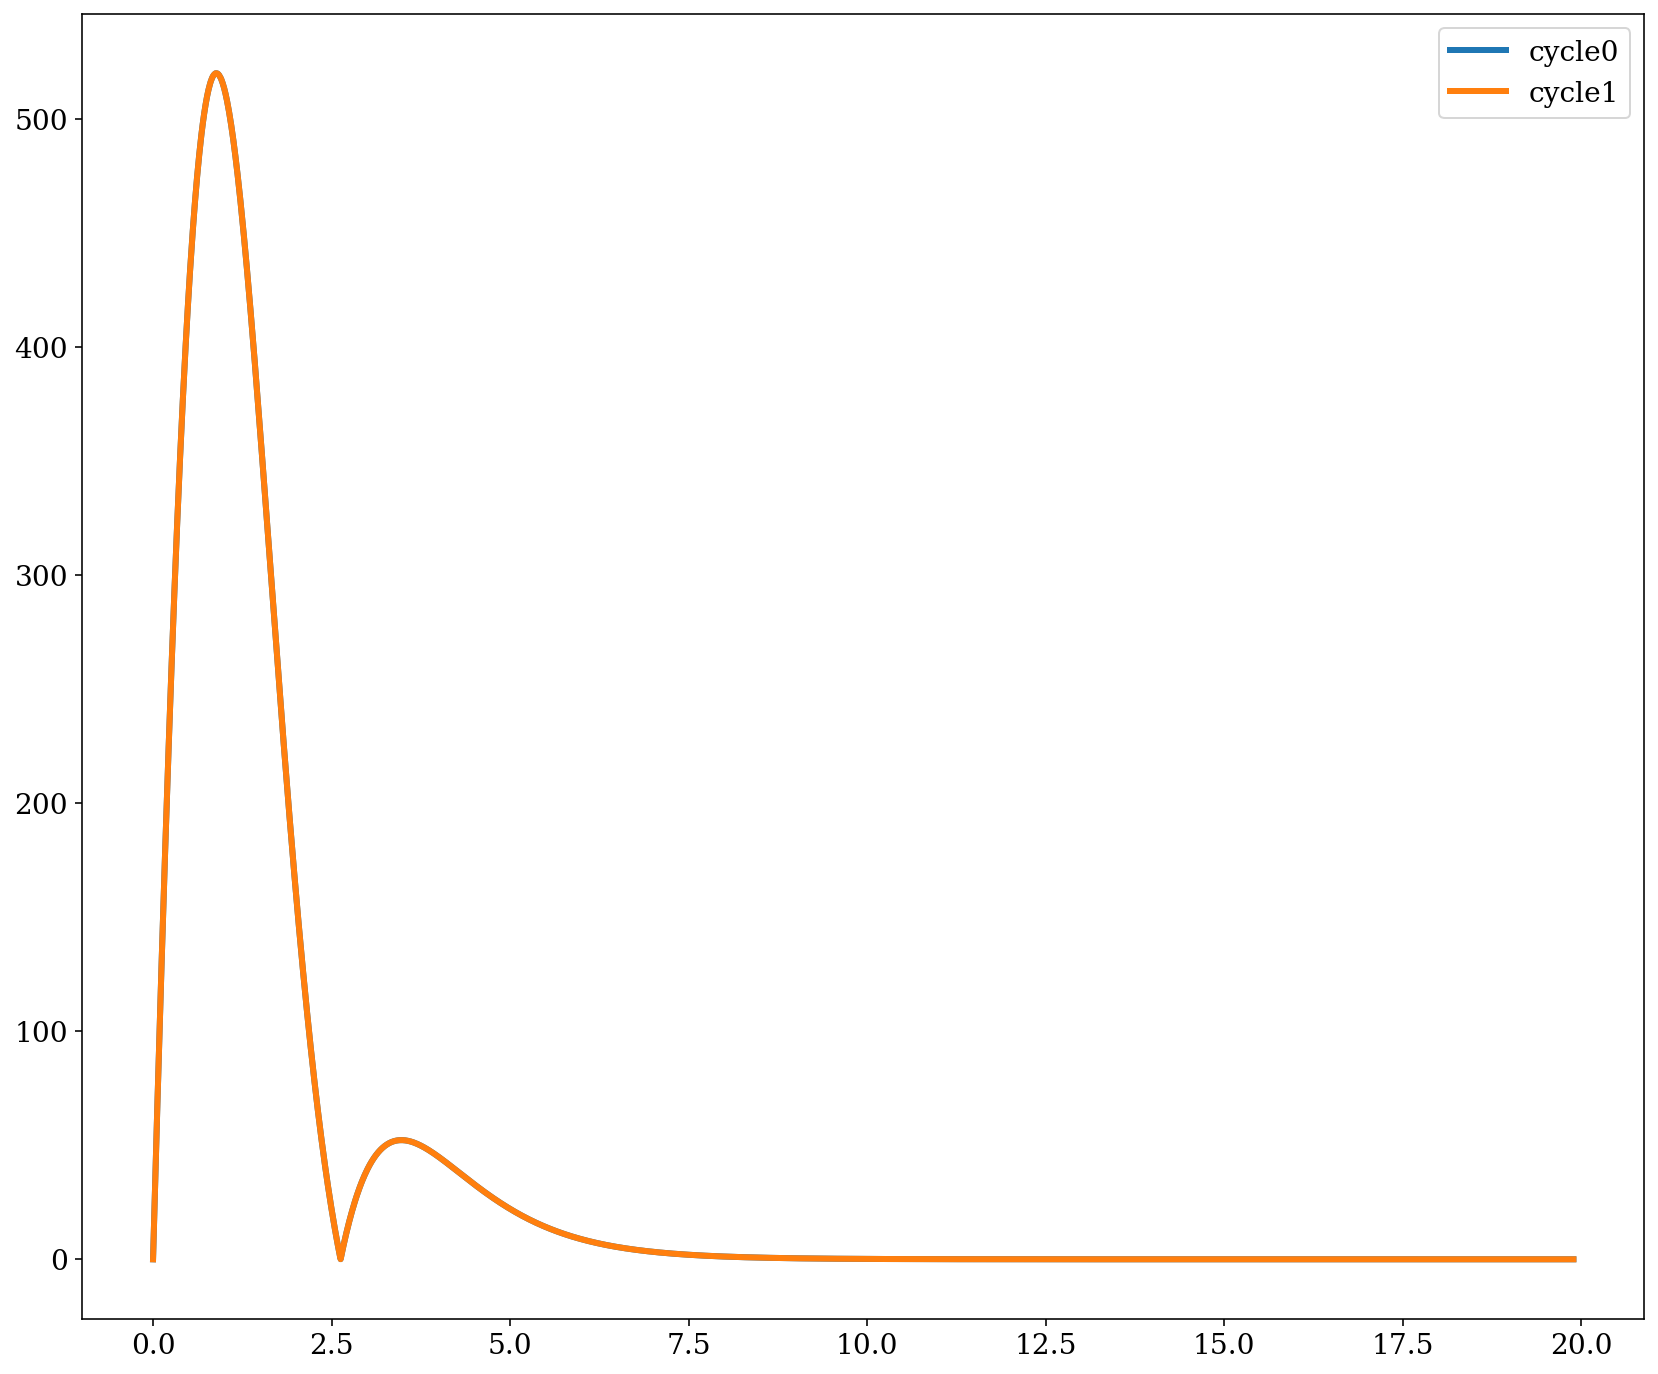

In [22]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(14,12))
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots()
for i in range(0,num_cycles):
    plt.plot(all_affinities[:,i],all_areas,linewidth=3,label='cycle'+str(i))
plt.legend()
#fig.savefig('G_4_2cycle_forcearea_bothcycles_2.png')